In [394]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import torch 
import torch.nn as nn
import math
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Some Helper Functions

In [395]:
def printUniqueCounts(df, columnName: str = None):
    column = None
    if columnName is None:
        column = df
    else:
        column = df[columnName]
    titles = column.unique()
    counts = []
    for title in titles:
        if pd.isna(title):
            count = sum(column.isnull())
        else:
            count = sum(column==title)
        counts.append([title,count])
    
    counts.sort(key=lambda x: -x[1])
    
    for item in counts:
        print(str(item[0])+": "+str(item[1]))

def torchEnumerator(tensor):
    array = tensor.detach().numpy()
    print("shape" + str(array.shape))
    return np.nditer(array)

In [396]:
trainData = pd.read_csv('train.csv')
print(trainData.shape)
trainData.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now it's time to clean up the data for use with our ML algorithm and do some feature engineering.

First lets see which columns have NaN / null values:

In [397]:
for column in trainData.columns:
    empty = len(trainData[trainData[column].isnull()])
    if empty>0: print(column + " has " + str(empty) + " missing data points")

Age has 177 missing data points
Cabin has 687 missing data points
Embarked has 2 missing data points


We will fill in missing age values with average age for now. In the future we may want to infer the age from the other columns, but for now this will have to suffice.

In [398]:
#fill in missing age values with average age
avgAge = trainData["Age"].mean()
print("Average age: ")
trainData["Age"].fillna(avgAge)

Average age: 


0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64

To gain a better idea of how to handle the missing values in embarked, lets first see how many people embarked from each port:

In [399]:
printUniqueCounts(trainData,"Embarked")

S: 644
C: 168
Q: 77
nan: 2


There are only 3 ports of embarcation, which makes this feature a good candidate for one-hot encoding. Missing values will simply be recorded as 'False' in all embarcation ports

In [400]:
trainData = pd.get_dummies(trainData,columns=["Embarked"])
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,False,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,False,False,True


The remaining column with missing data is Cabin. This is really two features: cabin area (the letter) and cabin number (the integer). For the sake of simplicity, lets assume the cabin number is not useful, but that the cabin area is. This is a reasonable assumption because the cabin area is likely to have a large effect on the location of the passenger, whereas the cabin number is less likely to have a large effect.

In [401]:

def getCabinLetter(cabin: str):
    if cabin is None or not isinstance(cabin,str): return None
    result =  re.search("^[a-zA-Z]*",cabin)
    if not result: return None
    return result[0]
    
cabinLetter = trainData["Cabin"].apply(getCabinLetter)

print("Cabin Letters")
printUniqueCounts(cabinLetter)


Cabin Letters
None: 687
C: 59
B: 47
D: 33
E: 32
A: 15
F: 13
G: 4
T: 1


We can see there are only 8 valid options for cabin letter. Being a small number this is a good candidate for one-hot encoding, again solving the missing data issue.

In [402]:
trainData["Cabin"] = cabinLetter
trainData = pd.get_dummies(trainData,columns=["Cabin"])
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,False,True,False,False,False,False,False,False,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,False,False,False,False,True,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,False,True,False,False,False,False,False,False,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,False,True,False,False,True,False,False,False,False,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,False,True,False,False,False,False,False,False,False,False


That covers all the missing data, so now we just need to deal with non-numeric data. Lets start by converting Male/Female and True/False to 0/1

In [403]:
trainData["Sex"] = trainData["Sex"]=="male"
trainData = trainData*1
trainData.head()
printUniqueCounts(cabinLetter)

None: 687
C: 59
B: 47
D: 33
E: 32
A: 15
F: 13
G: 4
T: 1


Name and Ticket remain as non-numeric data. We probably could do some NLP to make useful inferences out of the names, but that would be a lot of work and likely not yield a big difference in results. Ticket is also likely not to be very useful info. So lets just delete both columns.

In [404]:
trainData = trainData.drop(columns=["Name","Ticket","PassengerId"])
trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0
3,1,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0
4,0,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0


In [405]:
printUniqueCounts(trainData,"Survived")

0: 549
1: 342


Now lets do a little bit of feature engineering. Most of these features look pretty useful as is, but Sibsp and Parch stand out as being a potentially useful target for a little bit of engineering. 
SibSp: siblings and spouses
Parch: parents and children

We can combine these two to get family size. Total family size might be an important metric so lets make an additional column for family size 

In [406]:

trainData.insert(len(trainData.columns),"FamSize",trainData["SibSp"]+trainData["Parch"])
trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,0,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0,1
2,1,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0,0
3,1,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0,0


To complete our feature engineering we will to normalize the data. Lets use zscore normalization on Age and Fare:
**temporarily dropping Age to fix bugs**

In [407]:
from scipy.stats import zscore
colsToNormalize = ["Age","Fare"]
trainData[colsToNormalize] = trainData[colsToNormalize].apply(zscore)
trainData.head()

#drop age for now

trainData = trainData.drop(columns=["Age"])
trainData.head()



,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,0,3,1,1,0,-0.502445,0,0,1,0,0,0,0,0,0,0,0,1
1,1,1,0,1,0,0.786845,1,0,0,0,0,1,0,0,0,0,0,1
2,1,3,0,0,0,-0.488854,0,0,1,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0.420730,0,0,1,0,0,1,0,0,0,0,0,1
4,0,3,1,0,0,-0.486337,0,0,1,0,0,0,0,0,0,0,0,0


And in order to train the model without overfitting, lets create a training data set and a test data set upon which to verify generalization. We will use the first 20% of rows as test data and the last 80% of rows as training data. Lets write a class to handle our data storage and conversion to tensors

In [408]:
import pandas as pd
import torch

class DataSet:
    XTRAIN = "XTrain",
    XTEST = "XTest",
    YTRAIN = "YTrain",
    YTEST = "YTest",

    def __init__(self, X: pd.DataFrame, Y: pd.DataFrame, test_sample_count: int):
        if X.shape[0] != Y.shape[0]:
            raise ValueError("Row count mismatch between X and Y")
        
        #provide metadata
        self.input_count = X.shape[1]
        
        #separate training and test data
        training_sample_count = X.shape[0] - test_sample_count
        x_test = X.head(test_sample_count)
        x_train = X.tail(training_sample_count)
        y_test = Y.head(test_sample_count)
        y_train = Y.tail(training_sample_count)

        #initialize self.datasets
        datasets = [[x_train, y_train], [x_test, y_test]]
        self.datasets = datasets
        setByName = {DataSet.XTRAIN: x_train, DataSet.YTRAIN: y_train, DataSet.XTEST: x_test, DataSet.YTEST: y_test}

        indices = {}
        
        for i,pair in enumerate(datasets):
            for j,set in enumerate(pair):
                for setName in setByName:
                    if setByName[setName] is set: indices[setName] = (i,j)
                    
        self.indices = indices



        

        #convert data to torch tensor format
        for i, j in self.iterate_dataset_indices():
            set = self.datasets[i][j]
            tens = torch.tensor(set.values, dtype=torch.float32)
            if len(set.shape)==1:
                tens.unsqueeze_(1)
            self.datasets[i][j] = tens

        #make sure we can run gradient descent on x training data
        self.get(DataSet.XTRAIN).requires_grad_(True)

        
       


        
    def set(self, prop: str, value: torch.Tensor):
        if prop not in self.indices:
            raise ValueError(f"Property '{prop}' not found in indices")
        i, j = self.indices[prop]
        self.datasets[i][j] = value
    
    def get(self, prop: str) -> torch.Tensor:
        if prop not in self.indices:
            raise ValueError(f"Property '{prop}' not found in indices")
        i, j = self.indices[prop]
        return self.datasets[i][j]
    
    def iterate_dataset_indices(self):
        for i, data_set in enumerate(self.datasets):
            for j, _ in enumerate(data_set):
                yield i, j

    def SetToCuda(self):
        with torch.no_grad():
            for (i,j) in self.iterate_dataset_indices():
                self.datasets[i][j] = self.datasets[i][j].cuda()


Lets split the data between input (X) and output (Y) and store it as an instance of the newly created DataSet class

In [409]:
yColName = "Survived"
Y= trainData[yColName]
X = trainData.drop(columns=yColName)


rows = X.shape[0]
testRatio = .2
data = DataSet(X,Y,int(rows*testRatio))

Now we have prepared the data for our ML algorithm.

Lets create a model with 3 hidden layers, of 20, 8 and 5 neurons. Each hidden layer will have a ReLU activation function. The final output neuron will have a sigmoid activation function.
For the loss function we will use binary cross entropy.

To start, we will create a class to keep track of data sets

In [410]:

layerWeights = []
layerBiases = []

relu = nn.ReLU()
sigmoid = nn.Sigmoid()
layers = [[200,relu],[50,relu],[20,relu],[1,sigmoid]]#[node count, activation function]
layerCount = len(layers)
loss = nn.BCELoss()
learningRate = .08
initialParameterMin = -.1
initialParameterMax = .1
torch.manual_seed(20)


lastNodeCount = data.input_count
for layer in layers:
    nodeCount = layer[0]
    weights = torch.zeros((lastNodeCount,nodeCount))
    biases = torch.zeros(nodeCount)
    for arr in [weights,biases]:
        arr.uniform_(initialParameterMin,initialParameterMax)
        arr.requires_grad_(True)


    layerWeights.append(weights)
    layerBiases.append(biases)
    lastNodeCount = nodeCount

def printNan(V):
    nanCount = 0
    for item in torchEnumerator(V):
        if math.isnan(item): nanCount+=1
    ratio = nanCount/len(V)
    print(str(ratio*100)+"% Nan")

def forward(X: torch.Tensor):
    A = X
    for i in range(layerCount):
        layer = layers[i]
        function = layer[1]
        prod = torch.matmul(A,layerWeights[i])
        z = prod + layerBiases[i]
        A = function(z)
    return A

if torch.cuda.is_available():
    with torch.no_grad():
        data.SetToCuda()
        for i in range(len(layerWeights)):
            w = layerWeights[i].cuda()
            layerWeights[i] = w
            w.requires_grad_(True)
            b = layerBiases[i].cuda()
            b.requires_grad_(True)
            layerBiases[i] = b
print(torch.cuda.get_device_name(torch.cuda.current_device()))

def accuracy(prediction,target): return (sum(prediction==target)/len(prediction)).item()

def getPrediction(yHat): return yHat>0.5

losses = []
testAccuracies = []
trainAccuracies = []
epochs = []
iterations = 1000


parameters = [x for x in layerWeights] + [x for x in layerBiases]

optimizer = torch.optim.SGD(parameters,)

for epoch in range(iterations):
    xTrain = data.get(DataSet.XTRAIN)
    yHat = forward(xTrain)
    yTrain = data.get(DataSet.YTRAIN)
    l = loss(yHat,yTrain)

    trainPred = getPrediction(yHat)
    trainAcc = accuracy(trainPred,yTrain)

    xTest = data.get(DataSet.XTEST)
    yHatTest = forward(xTest)
    prediction = getPrediction(yHatTest)
    yTest = data.get(DataSet.YTEST)
    testAcc = accuracy(prediction,yTest)

    
    l.backward()
    with torch.no_grad():
        for i in range(layerCount):
            weights = layerWeights[i]
            biases = layerBiases[i]
            weights-=weights.grad*learningRate
            biases-=biases.grad*learningRate
            weights.grad.zero_()
            biases.grad.zero_()

    epochs.append(epoch)
    losses.append(l.item())
    testAccuracies.append(testAcc)
    trainAccuracies.append(trainAcc)





NVIDIA GeForce GTX 1080


Lets plot the results

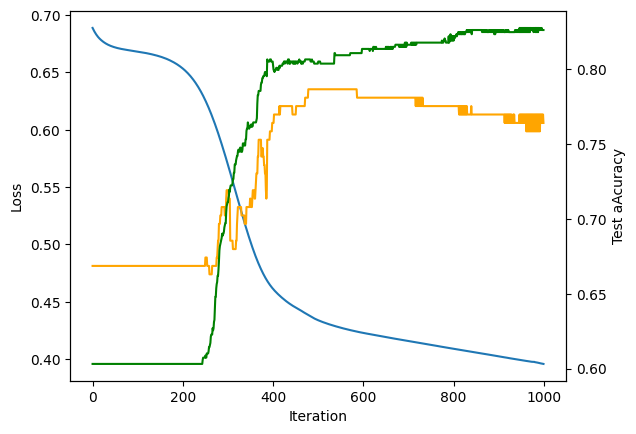

Peak test data accuracy: 0.7865168452262878 at epoch 478


In [413]:
fig = plt.figure()
ax = plt.gca()
ax.plot(epochs,losses)
ax2 = ax.twinx()
ax2.plot(epochs,testAccuracies,color="orange")
ax2.plot(epochs,trainAccuracies,color="green")
ax.set_ylabel("Loss")
ax2.set_ylabel("Test aAcuracy")
ax.set_xlabel("Iteration")
plt.show()

maxIndex = np.argmax(testAccuracies)
print(f"Peak test data accuracy: {testAccuracies[maxIndex]} at epoch {maxIndex}")

In [412]:
print(weights.requires_grad)


True
